Đang tải dữ liệu từ D:\1-REFERENCES\11-URA\Beijing-PM2.5.csv...
Đang xử lý dữ liệu...
Các features sẽ được sử dụng (sau khi one-hot): ['pm2.5', 'dew_point', 'temperature', 'pressure', 'wind_speed', 'hours_snow', 'hours_rain', 'wind_direction_NW', 'wind_direction_SE', 'wind_direction_cv']
Đang chuẩn hóa dữ liệu...
Cột target 'pm2.5' ở vị trí index: 0
Tổng số features (bao gồm cả target): 10
Đang tạo cửa sổ trượt (phiên bản multivariate)...

Kích thước dữ liệu huấn luyện (Training): X=(33381, 24, 10), y=(33381,)
Kích thước dữ liệu kiểm tra (Testing): X=(8328, 24, 10), y=(8328,)

Đã tạo PyTorch DataLoaders với Batch Size = 32

--- SPRINT 2: Bắt đầu xây dựng mô hình LSTM trên cuda ---


C:\Users\micha\AppData\Local\Temp\ipykernel_7264\2079974362.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pm2.5'] = df['pm2.5'].fillna(method='ffill').fillna(method='bfill')
C:\Users\micha\AppData\Local\Temp\ipykernel_7264\2079974362.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill').fillna(method='bfill')


LSTMModel(
  (lstm1): LSTM(10, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 50, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Bắt đầu Huấn luyện mô hình (PyTorch)...
Epoch [1/50], Train Loss: 0.003778, Val Loss: 0.006605
Epoch [2/50], Train Loss: 0.001621, Val Loss: 0.001595
Epoch [3/50], Train Loss: 0.001018, Val Loss: 0.000682
Epoch [4/50], Train Loss: 0.000817, Val Loss: 0.000515
Epoch [5/50], Train Loss: 0.000767, Val Loss: 0.000502
Epoch [6/50], Train Loss: 0.000767, Val Loss: 0.000544
Epoch [7/50], Train Loss: 0.000738, Val Loss: 0.000566
Epoch [8/50], Train Loss: 0.000739, Val Loss: 0.000554
Epoch [9/50], Train Loss: 0.000709, Val Loss: 0.000558
Epoch [10/50], Train Loss: 0.000686, Val Loss: 0.000615
Epoch [11/50], Train Loss: 0.000707, Val Loss: 0.000657
Epoch [12/50], Train Loss: 0.000676, Val Loss: 0.000581
Epoch [13/50], Train Loss: 0.000709, Val Loss: 0.

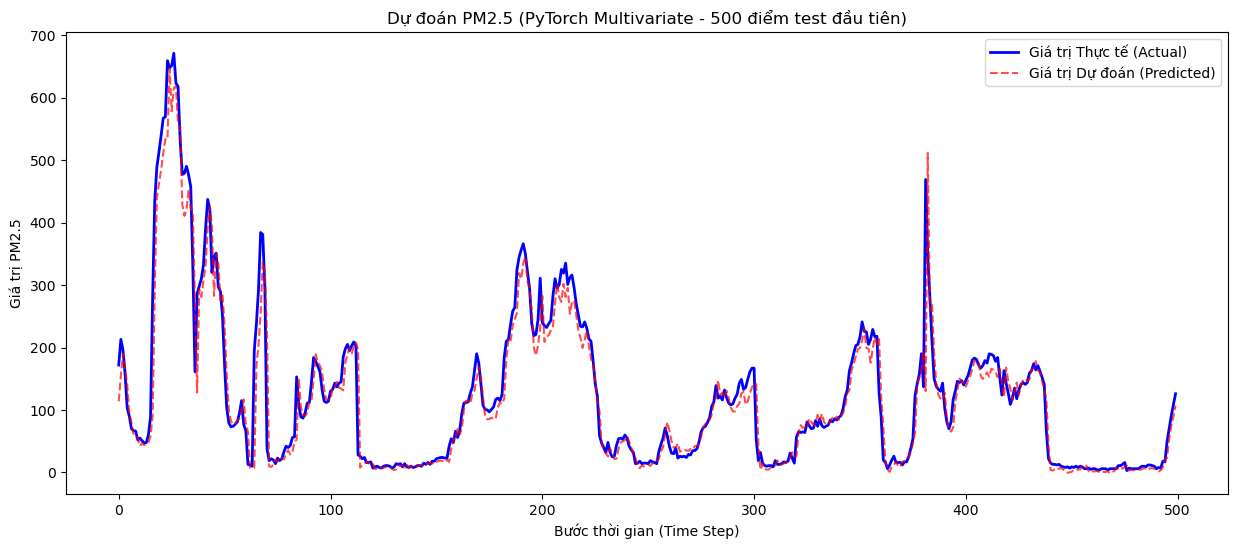

In [ ]:
# --- BÌNH LUẬN PYTORCH: Imports cần thiết ---
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import datetime
import os 

DATA_FILE = r'D:\1-REFERENCES\11-URA\Beijing-PM2.5.csv' 

if not os.path.exists(DATA_FILE):
    print(f"Lỗi: Không tìm thấy file '{DATA_FILE}'.")
    print("Vui lòng tải lên file CSV đầy đủ và đổi tên thành 'beijing_pm25.csv' hoặc cập nhật biến DATA_FILE.")
else:
    print(f"Đang tải dữ liệu từ {DATA_FILE}...")
    df = pd.read_csv(DATA_FILE)

    # --- 1.1: Xử lý dữ liệu (Clean data) ---
    print("Đang xử lý dữ liệu...")
    try:
        df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        df = df.set_index('datetime')
    except Exception as e:
        print(f"Lỗi khi tạo datetime index: {e}")
        pass

    df['pm2.5'] = df['pm2.5'].fillna(method='ffill').fillna(method='bfill')
    df = df.dropna(subset=['pm2.5']) 

    features_to_use = ['pm2.5', 'dew_point', 'temperature', 'pressure', 'wind_speed', 'hours_snow', 'hours_rain', 'wind_direction']
    df_features = df[features_to_use].copy()
    df_features = pd.get_dummies(df_features, columns=['wind_direction'], drop_first=True)
    df_features = df_features.fillna(method='ffill').fillna(method='bfill')
    df_features = df_features.fillna(0)
    
    print(f"Các features sẽ được sử dụng (sau khi one-hot): {df_features.columns.tolist()}")
    
    # --- 1.2: Chuẩn hóa giá trị (Multivariate) ---
    print("Đang chuẩn hóa dữ liệu...")
    
    split = int(0.8 * len(df_features))
    train_df = df_features.iloc[:split]
    test_df = df_features.iloc[split:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(train_df)
    scaled_test = scaler.transform(test_df)
    
    target_col_index = df_features.columns.tolist().index('pm2.5')
    num_features = scaled_train.shape[1] 
    print(f"Cột target 'pm2.5' ở vị trí index: {target_col_index}")
    print(f"Tổng số features (bao gồm cả target): {num_features}")

    # --- 1.3: Tạo sliding windows (Multivariate) ---
    print("Đang tạo cửa sổ trượt (phiên bản multivariate)...")
    
    def create_sliding_windows_multi(data, sequence_length, target_col_index, target_step=1):
        X, y = [], []
        for i in range(len(data) - sequence_length - target_step + 1):
            window = data[i:(i + sequence_length), :]
            X.append(window)
            target = data[i + sequence_length + target_step - 1, target_col_index]
            y.append(target)
        return np.array(X), np.array(y)

    SEQUENCE_LENGTH = 24 
    TARGET_STEP = 1
    
    X_train, y_train = create_sliding_windows_multi(scaled_train, SEQUENCE_LENGTH, target_col_index, TARGET_STEP)
    X_test, y_test = create_sliding_windows_multi(scaled_test, SEQUENCE_LENGTH, target_col_index, TARGET_STEP)

    print(f"\nKích thước dữ liệu huấn luyện (Training): X={X_train.shape}, y={y_train.shape}")
    print(f"Kích thước dữ liệu kiểm tra (Testing): X={X_test.shape}, y={y_test.shape}")
    
    # 1. Chuyển đổi NumPy arrays sang PyTorch Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Thêm 1 chiều
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Thêm 1 chiều

    # 2. Tạo TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # 3. Tạo DataLoaders
    BATCH_SIZE = 32 # Giống 'batch_size' trong Keras
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False) # shuffle=False rất quan trọng
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"\nĐã tạo PyTorch DataLoaders với Batch Size = {BATCH_SIZE}")


    # --- SPRINT 2: Thiết kế và huấn luyện mô hình (Phiên bản PyTorch) ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n--- SPRINT 2: Bắt đầu xây dựng mô hình LSTM trên {device} ---")

    # --- BÌNH LUẬN PYTORCH: 2.1 Định nghĩa mô hình (Tương đương model.add) ---
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers=1):
            super(LSTMModel, self).__init__()
            # Cấu trúc tương đương Keras: LSTM -> Dropout -> LSTM -> Dropout -> Dense
            
            # Lớp LSTM đầu tiên (tương đương Keras units=50, return_sequences=True)
            self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.dropout1 = nn.Dropout(0.2)
            
            # Lớp LSTM thứ hai (tương đương Keras units=50, return_sequences=False)
            self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            self.dropout2 = nn.Dropout(0.2)
            
            # Lớp Linear (tương đương Keras Dense(1))
            self.linear = nn.Linear(hidden_size, 1)

        def forward(self, x):
            # x shape: [batch_size, sequence_length, num_features]
            
            # Lớp 1
            # Tương đương return_sequences=True
            out1, _ = self.lstm1(x) 
            out1 = self.dropout1(out1)
            
            # Lớp 2
            # out2: [batch, seq_len, hidden_size]
            out2, (hidden_n, cell_n) = self.lstm2(out1)
            
            # Tương đương return_sequences=False (chỉ lấy output của time step cuối cùng)
            last_time_step_output = out2[:, -1, :] 
            
            out = self.dropout2(last_time_step_output)
            
            # Lớp Linear
            predictions = self.linear(out)
            return predictions

    # Khởi tạo mô hình
    model = LSTMModel(input_size=num_features, hidden_size=50).to(device)
    print(model) # In ra cấu trúc mô hình

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

    log_dir = os.path.join("logs", "fit_multi_pytorch", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    writer = SummaryWriter(log_dir)
    
    # Biến cho Early Stopping thủ công
    PATIENCE = 10 # Giống Keras
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model_pytorch.pth' # Để lưu model tốt nhất

    NUM_EPOCHS = 50 # Giống Keras
    print("\nBắt đầu Huấn luyện mô hình (PyTorch)...")

    for epoch in range(NUM_EPOCHS):
        # --- Training ---
        model.train() 
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 1. Forward pass
            outputs = model(batch_X)
            
            # 2. Calculate loss
            loss = criterion(outputs, batch_y)
            
            # 3. Backward pass và optimize
            optimizer.zero_grad() # Xóa gradient cũ
            loss.backward()       # Tính gradient mới
            optimizer.step()      # Cập nhật trọng số
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # --- Validation ---
        model.eval() # Đặt model ở chế độ evaluation (tắt dropout)
        total_val_loss = 0
        
        with torch.no_grad(): # Không cần tính gradient khi validation
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(test_loader)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Lưu model tốt nhất (tương đương restore_best_weights=True)
            torch.save(model.state_dict(), best_model_path)
            #print("Validation loss decreased, saving model.")
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}!")
            break

    writer.close()
    print("--- Huấn luyện mô hình hoàn tất ---")
    
    # Tải lại trọng số tốt nhất đã lưu
    print(f"Đang tải trọng số tốt nhất từ {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))


    print("\n--- SPRINT 3: Bắt đầu Đánh giá mô hình ---")
    model.eval() 
    y_pred_scaled_list = []
    
    with torch.no_grad():
        y_pred_scaled_tensor = model(X_test_tensor.to(device))
    
    y_pred_scaled = y_pred_scaled_tensor.cpu().numpy()
    # 1. Đảo ngược y_pred (Dự đoán)
    dummy_pred = np.zeros((len(y_pred_scaled), num_features))
    dummy_pred[:, target_col_index] = y_pred_scaled.flatten()
    y_pred = scaler.inverse_transform(dummy_pred)[:, target_col_index]

    # 2. Đảo ngược y_test (Thực tế)
    # y_test đã là NumPy array, không cần .cpu().numpy()
    y_test_reshaped = y_test.reshape(-1, 1) 
    dummy_test = np.zeros((len(y_test_reshaped), num_features))
    dummy_test[:, target_col_index] = y_test_reshaped.flatten()
    y_test_orig = scaler.inverse_transform(dummy_test)[:, target_col_index]

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    mae = mean_absolute_error(y_test_orig, y_pred)

    print("\nKết quả đánh giá trên tập Test (PyTorch - Multivariate):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    
    print("Đang tạo biểu đồ trực quan hóa kết quả...")
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_orig[:500], label='Giá trị Thực tế (Actual)', color='blue', linewidth=2)
    plt.plot(y_pred[:500], label='Giá trị Dự đoán (Predicted)', color='red', alpha=0.7, linestyle='--')
    plt.title('Dự đoán PM2.5 (PyTorch Multivariate - 500 điểm test đầu tiên)')
    plt.xlabel('Bước thời gian (Time Step)')
    plt.ylabel('Giá trị PM2.5')
    plt.legend()
    
    plot_filename = 'pm25_prediction_vs_actual_pytorch_multivariate.png'
    plt.savefig(plot_filename)
    print(f"Đã lưu biểu đồ dự đoán vào {plot_filename}")
    
    print(f"\n--- Hoàn tất cả 3 Sprints (PyTorch) ---")
    print(f"Để xem TensorBoard, mở terminal và chạy lệnh:")
    print(f"tensorboard --logdir={os.path.join('logs', 'fit_multi_pytorch')}")